In [ ]:
# CEEMDAN stock market filtering application
Henry Chacon

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime
from datetime import date
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import load_model
from tensorflow.keras import backend
from keras import losses
import csv
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from PyEMD import CEEMDAN

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def weight_absolute_percentage_error(y_true, y_pred): 
    """Calculates WAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# define a function to convert a vector of time series into a 2D matrix
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix=[]
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix

In [3]:
# Company ticker, initial period, final period
ticker = 'AAPL'
start_day = datetime.datetime(2017, 1, 1)
EPOCHS = 300
loss_MSE = False # If it is False, the mean_absolute_error will be selected
tanh_funct = True
########
end_day = date.today()
# For alternative end date activate the follow row:
# end_day = datetime.datetime(2019, 10, 31)

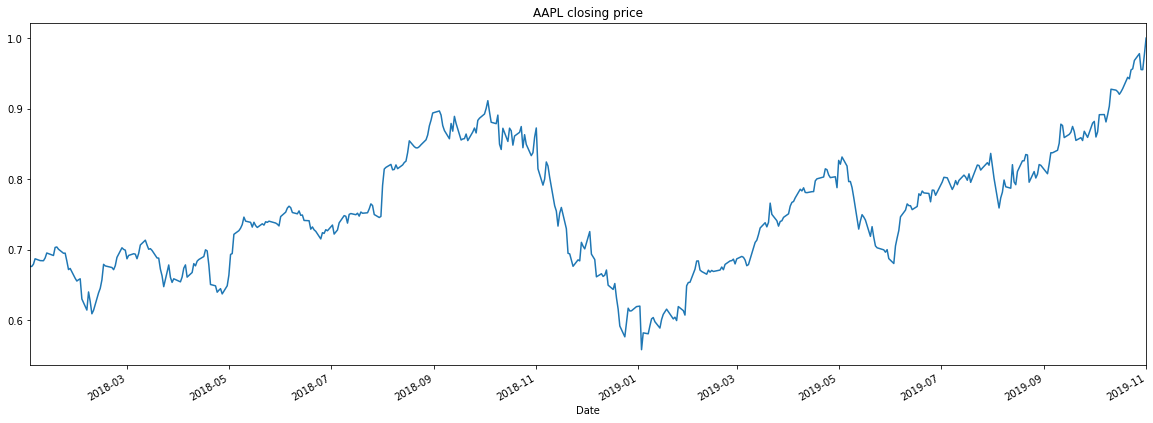

Number of IMFs: 6, ticker: AAPL

Original series MAPE = 6.0033227364422554, WAPE = 6.179296222638479


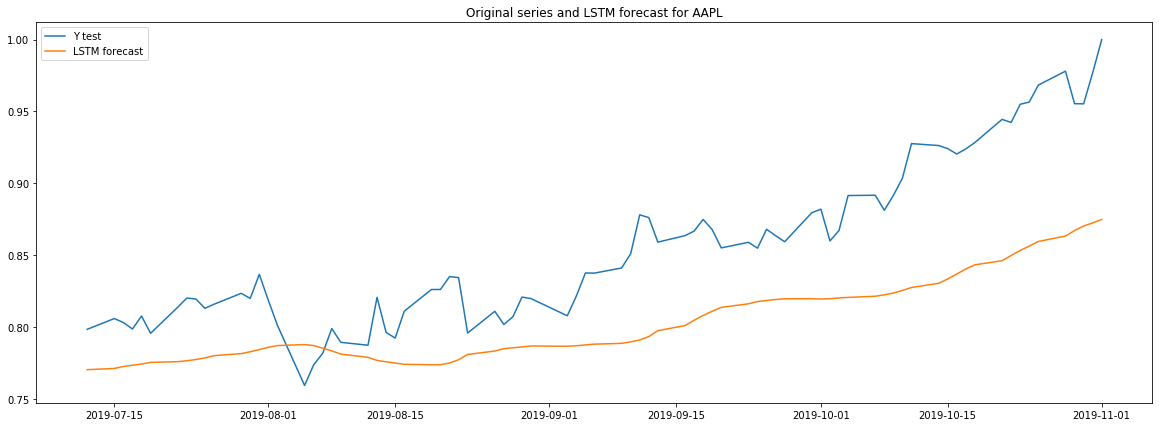

Original series MAPE = 147.89569881259465, WAPE = 13466.937512601124


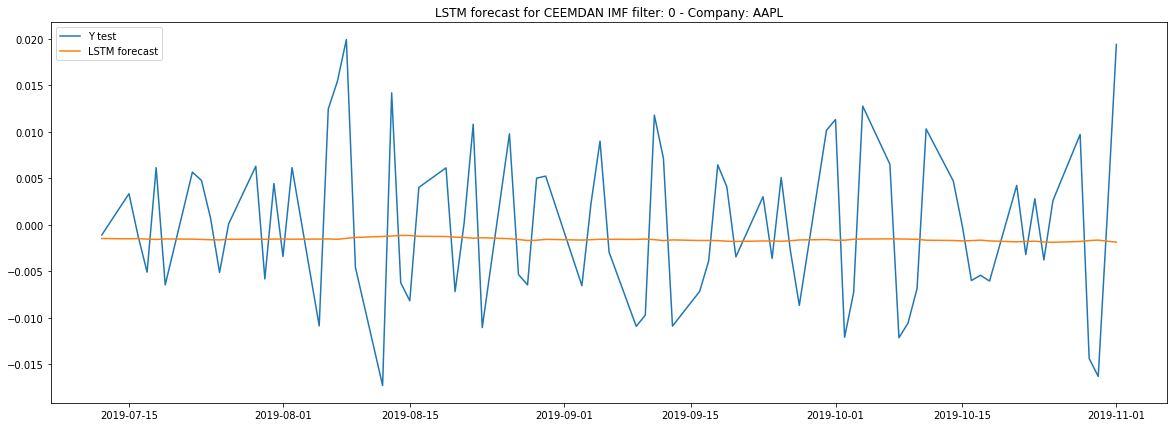

Original series MAPE = 116.57955972268704, WAPE = -3290.5419947038417


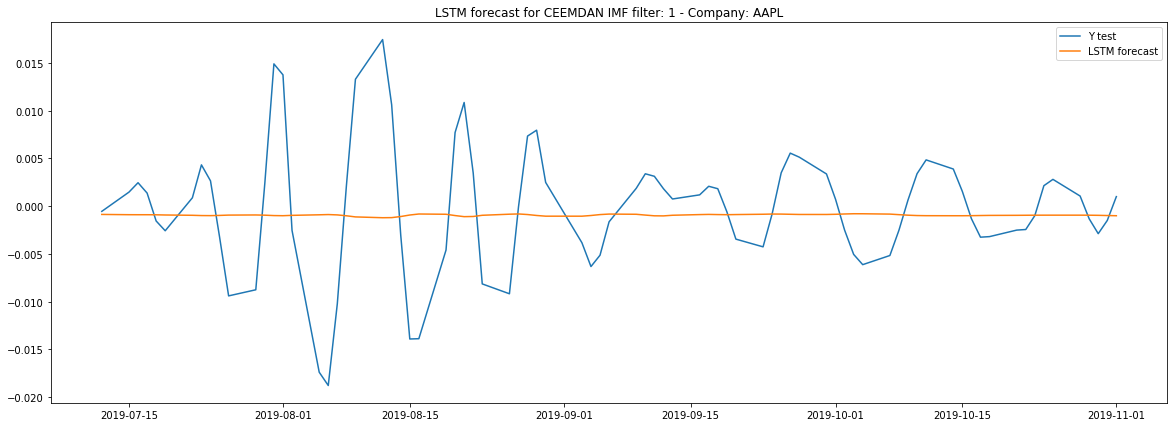

Original series MAPE = 126.70821049215411, WAPE = 1334.9649303252952


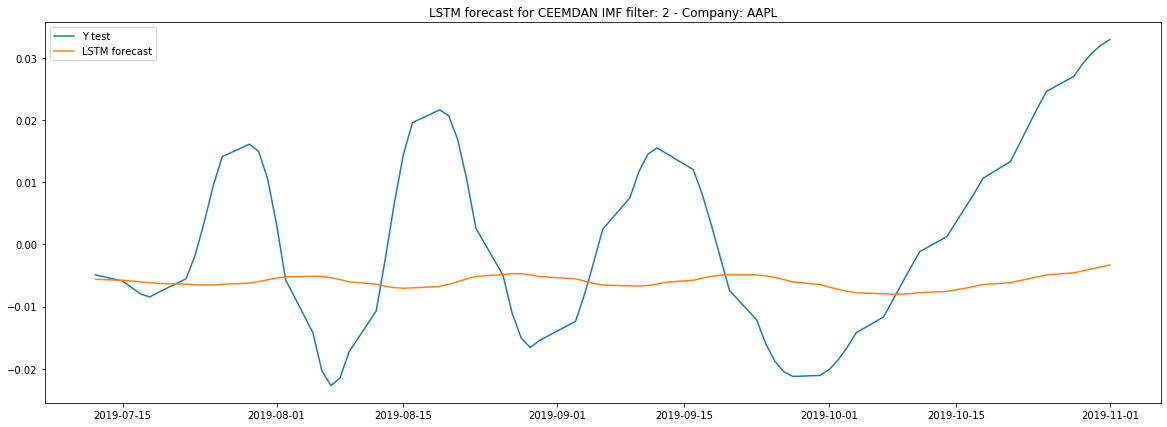

Original series MAPE = 141.79188449891396, WAPE = 152.52564646061288


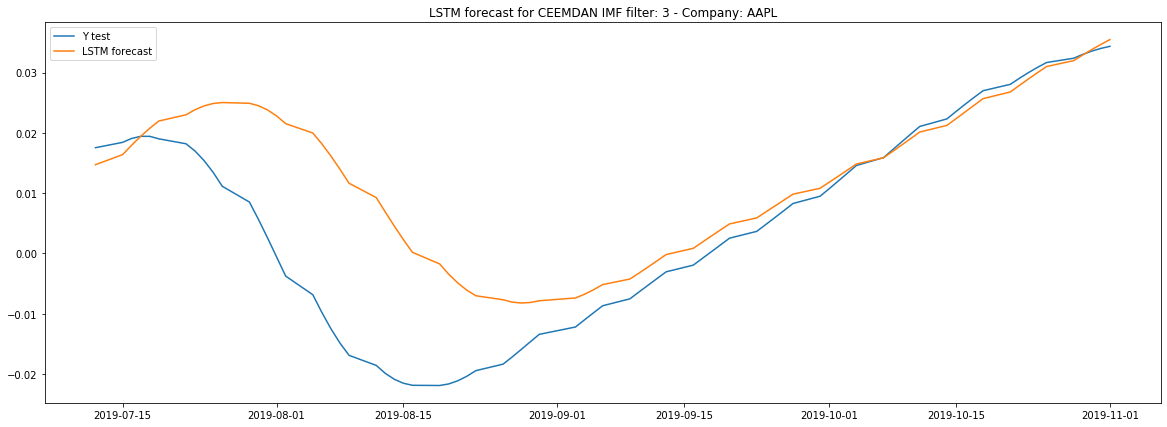

Original series MAPE = 200.95456126631035, WAPE = 41.24127970977424


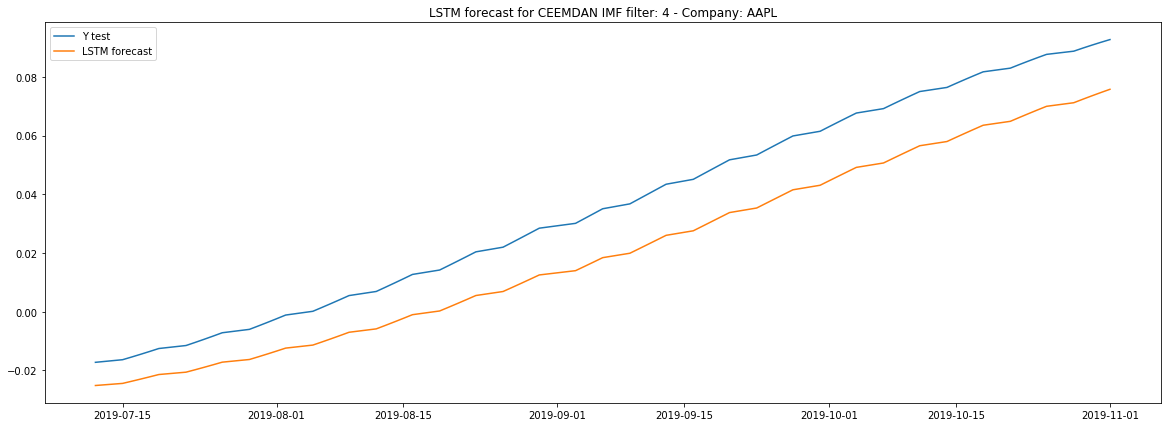

Original series MAPE = 10.23215161899202, WAPE = 10.233268566392294


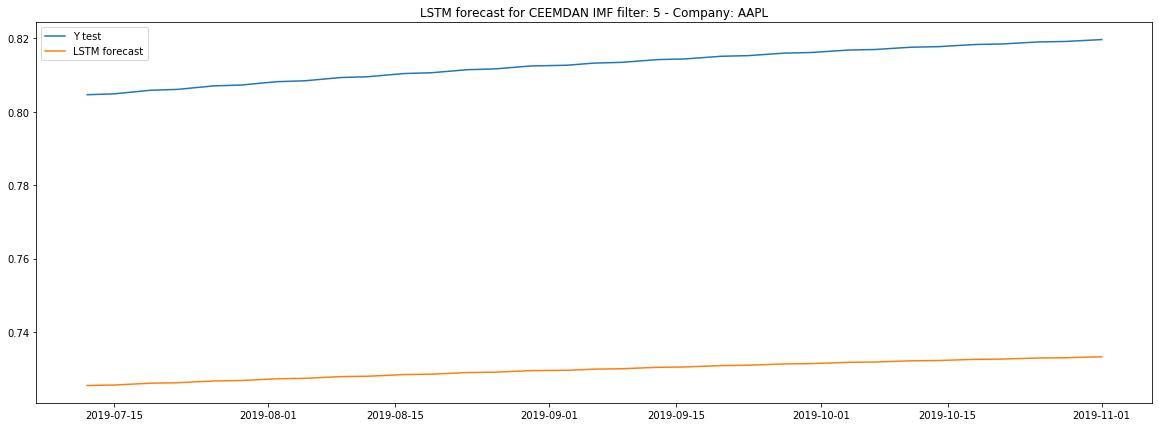

,Company,Filter,Source,MAPE,WAPE
0,AAPL,CEEMDAN,Original,6.003323,6.179296
1,AAPL,CEEMDAN,IMF 0,147.895699,13466.937513
2,AAPL,CEEMDAN,IMF 1,116.579560,-3290.541995
3,AAPL,CEEMDAN,IMF 2,126.708210,1334.964930
4,AAPL,CEEMDAN,IMF 3,141.791884,152.525646
5,AAPL,CEEMDAN,IMF 4,200.954561,41.241280
6,AAPL,CEEMDAN,IMF 5,10.232152,10.233269


++++++ Process finished


In [4]:
filter_name = 'CEEMDAN'
results = pd.DataFrame()
data = pdr.get_data_yahoo(ticker, start=start_day, end=end_day)
data['Close_norm'] = data['Close'] / max(data['Close'])

var_selection = 'Close_norm'
fig = plt.figure(figsize=(20,7))
data[var_selection].plot()
plt.title('{} closing price'.format(ticker))
# fig.savefig(ticker'plot.png')
plt.savefig('./figures/' + filter_name + '_' + ticker + '_original.png')
plt.show()

emd = CEEMDAN()
data_emd = emd(np.array(data[var_selection]))
IMF_num = data_emd.shape[0]
print('Number of IMFs: {}, ticker: {}'.format(IMF_num, ticker))

# LSTM model
# Sequence length is the window size for the LSTM model. Try with different sizes 
sequence_length = 14
vector = data[var_selection].tolist()
# convert the vector to a 2D matrix
matrix = convertSeriesToMatrix(vector, sequence_length)
matrix = np.array(matrix)

# From the dimension of the matrix try different values 
train_row = int(np.round(len(vector)*0.8))
train_set = matrix[:train_row,:]

# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1]

# the test set
X_test = matrix[train_row:, :-1]
y_test = matrix[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM
model = Sequential()
data_dim=1
timesteps= sequence_length - 1
# layer 1: LSTM
model.add(LSTM(20, return_sequences=True, input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 50
model.add(Dropout(0.2))
model.add(LSTM(units=30, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
if tanh_funct:
    model.add(Dense(units=1, activation='tanh'))
else:
    model.add(Dense(units=1, activation='linear'))
# compile the model
if loss_MSE:
    model.compile(loss="mean_squared_error", optimizer="adam")
else:
    model.compile(loss=losses.mean_absolute_error, optimizer="adam")

# Model weights
Wsave = model.get_weights()

model.set_weights(Wsave)
model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.05, verbose=0)

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))
mape = mean_absolute_percentage_error(y_test, np.squeeze(predicted_values))
wape = weight_absolute_percentage_error(y_test, np.squeeze(predicted_values))
print('Original series MAPE = {}, WAPE = {}'.format(mape, wape))
results = results.append(pd.DataFrame({'Company': ticker, 'Filter': filter_name, 'Source': 'Original', 'MAPE': mape, 'WAPE': wape}, index=[len(results)]))
forecast_comp = pd.DataFrame(list(zip(y_test, np.squeeze(predicted_values))), columns=['Y_test', 'LSTM predicted'], index=data.iloc[len(data)-len(X_test):, ].index)
fig = plt.figure(figsize=(20,7))
plt.plot(forecast_comp)
plt.title('Original series and LSTM forecast for {}'.format(ticker))
plt.legend(['Y test', 'LSTM forecast'], loc='best')
plt.savefig('./figures/' + filter_name + '_' + ticker + '_LSTM.png')
plt.show()

# LSTM model forecast for each IMF filter
for filter_id in range(IMF_num):
    vector = data_emd[filter_id].tolist()
    # convert the vector to a 2D matrix
    matrix = convertSeriesToMatrix(vector, sequence_length)
    matrix = np.array(matrix)

    # From the dimension of the matrix try different values 
    train_row = int(np.round(len(vector)*0.8))
    train_set = matrix[:train_row,:]

    # the training set
    X_train = train_set[:, :-1]
    # the last column is the true value to compute the mean-squared-error loss
    y_train = train_set[:, -1]

    # the test set
    X_test = matrix[train_row:, :-1]
    y_test = matrix[train_row:, -1]

    # the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    model.set_weights(Wsave)
    model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.05, verbose=0)
    
    # get the predicted values
    predicted_values = model.predict(X_test)
    num_test_samples = len(predicted_values)
    predicted_values = np.reshape(predicted_values, (num_test_samples,1))
    mape = mean_absolute_percentage_error(y_test, np.squeeze(predicted_values))
    wape = weight_absolute_percentage_error(y_test, np.squeeze(predicted_values))
    print('Original series MAPE = {}, WAPE = {}'.format(mape, wape))
    results = results.append(pd.DataFrame({'Company': ticker, 'Filter': filter_name, 'Source': 'IMF {}'.format(filter_id), 'MAPE': mape, 'WAPE': wape}, index=[len(results)]))
    forecast_comp = pd.DataFrame(list(zip(y_test, np.squeeze(predicted_values))), columns=['Y_test', 'LSTM predicted'], index=data.iloc[len(data)-len(X_test):, ].index)
    fig = plt.figure(figsize=(20,7))
    plt.plot(forecast_comp)
    plt.title('LSTM forecast for {} IMF filter: {} - Company: {}'.format(filter_name, filter_id, ticker))
    plt.legend(['Y test', 'LSTM forecast'], loc='best')
    plt.savefig('./figures/' + filter_name + '_' + ticker + '_Forecast_IMF_' + str(filter_id) + '.png')
    plt.show()
    
display(results)
results.to_csv('./summary/' + filter_name + '_' + ticker + '_summary.csv', index = None, header=True)
print('++++++ Process finished')

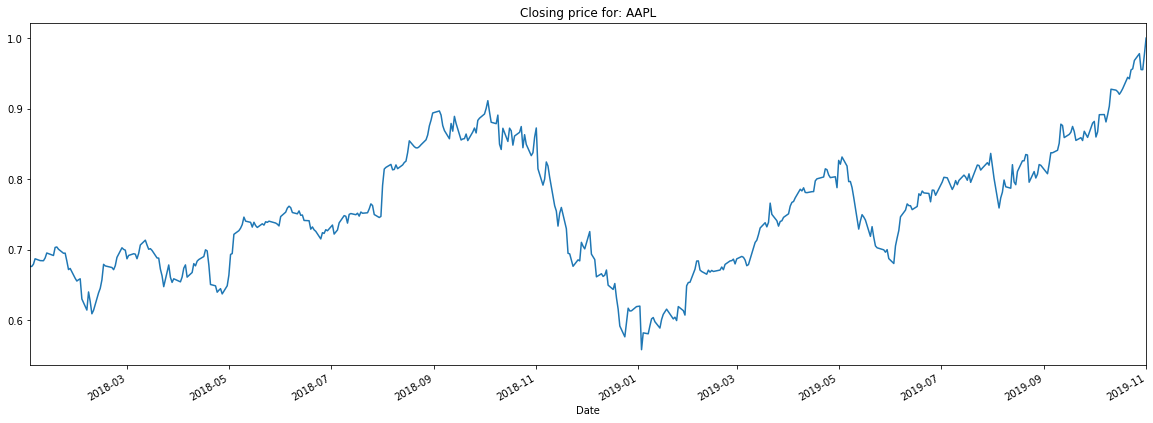

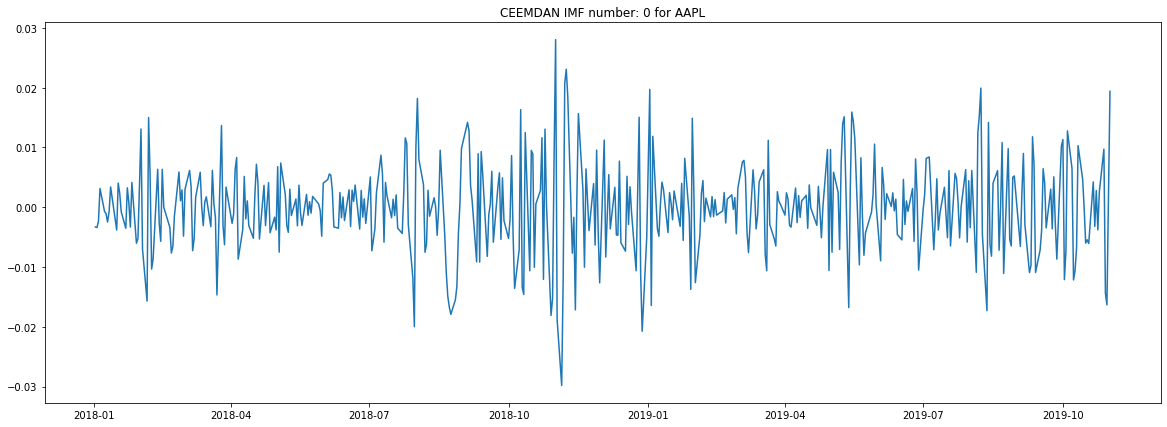

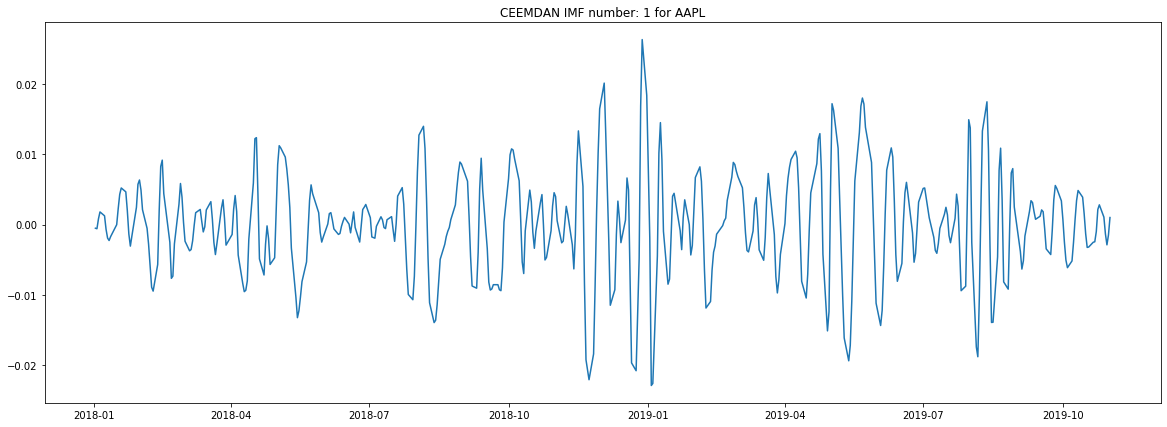

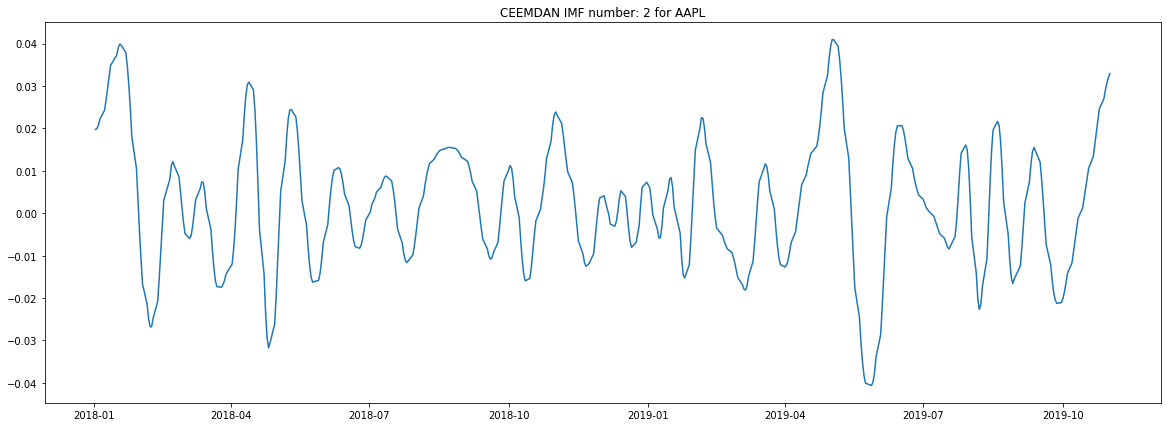

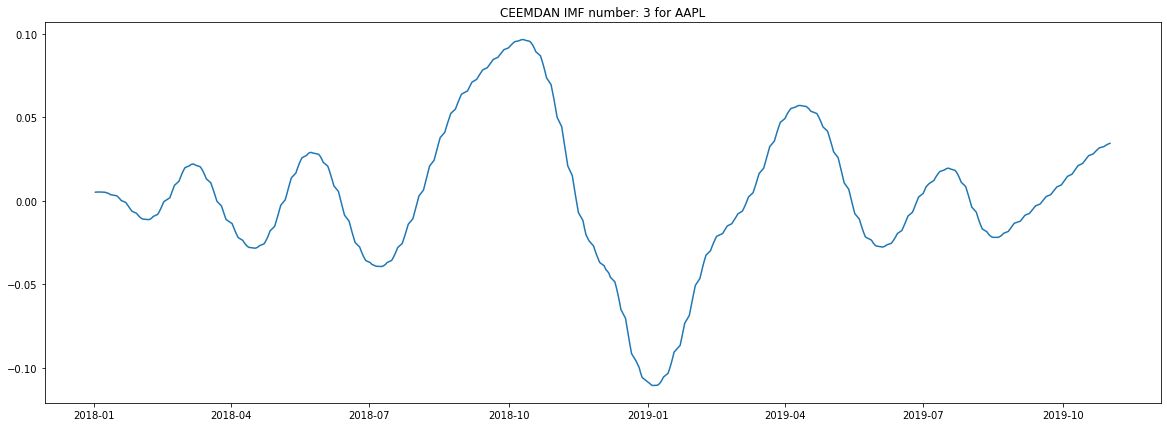

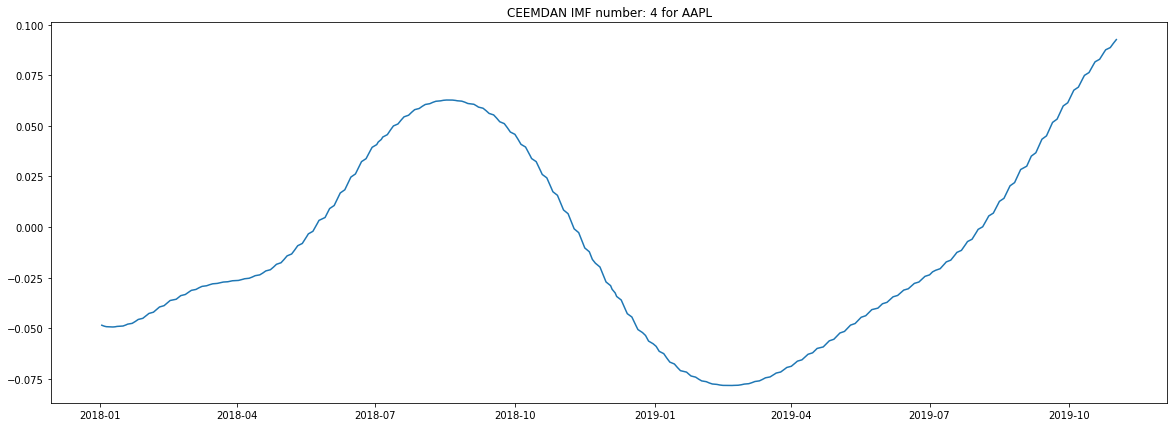

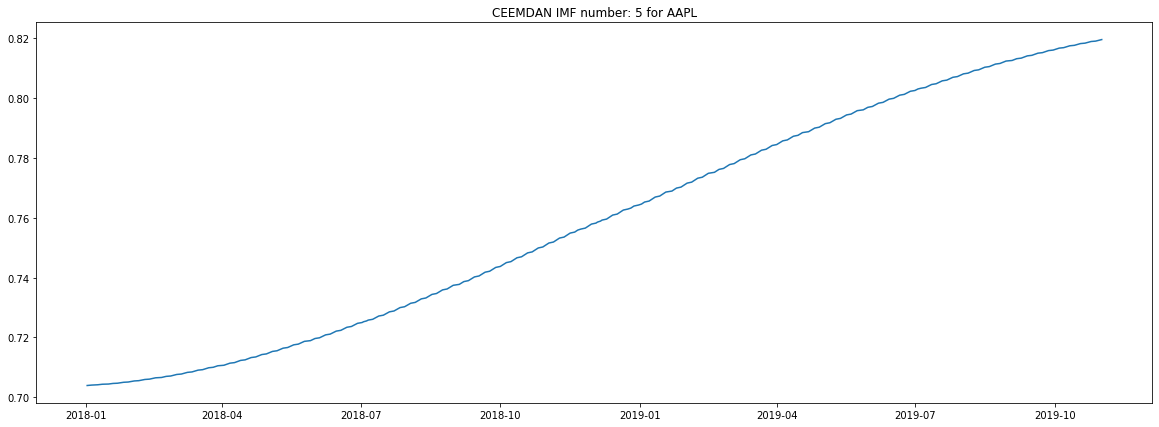

In [5]:
# Code to plot the full series by filter 
fig = plt.figure(figsize=(20,7))
data[var_selection].plot()
plt.title('Closing price for: {}'.format(ticker))
plt.show()

for i in range(data_emd.shape[0]):
    fig = plt.figure(figsize=(20,7))
    plt.plot(pd.DataFrame(data_emd[i], columns=['IMF {}'.format(i)], index=data.index))
    plt.title('{} IMF number: {} for {}'.format(filter_name, i, ticker))
    plt.savefig('./figures/' + filter_name + '_' + ticker + '_IMF_' + str(i) + '.png')
    plt.show()

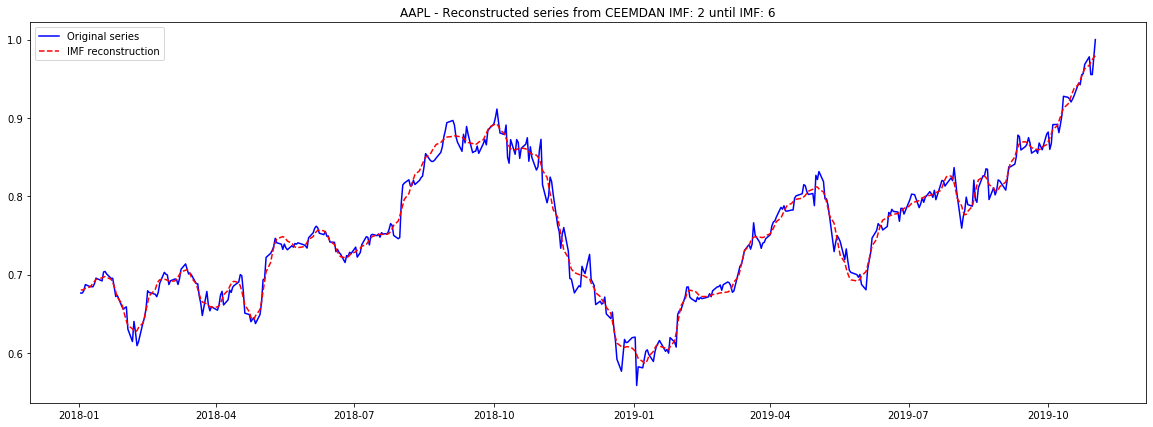

In [6]:
# Reconstructing the series from filter X until the total number of filters
k = 2
reconstructed = []
reconstructed = data_emd[k].copy()
for i in range(k+1, data_emd.shape[0]):
    reconstructed += data_emd[i]
data['EMD'] = reconstructed   
fig = plt.figure(figsize=(20,7))
plt.plot(data[var_selection], color='blue', label = 'Original series')
plt.plot(data['EMD'], color='red', ls='--', label = 'IMF reconstruction')
plt.legend(loc='best')
plt.title('{} - Reconstructed series from {} IMF: {} until IMF: {}'.format(ticker, filter_name, k, data_emd.shape[0]))
plt.savefig('./figures/' + filter_name + '_' + ticker + '_Reconstructed_From_' + str(k) + '.png')
plt.show()

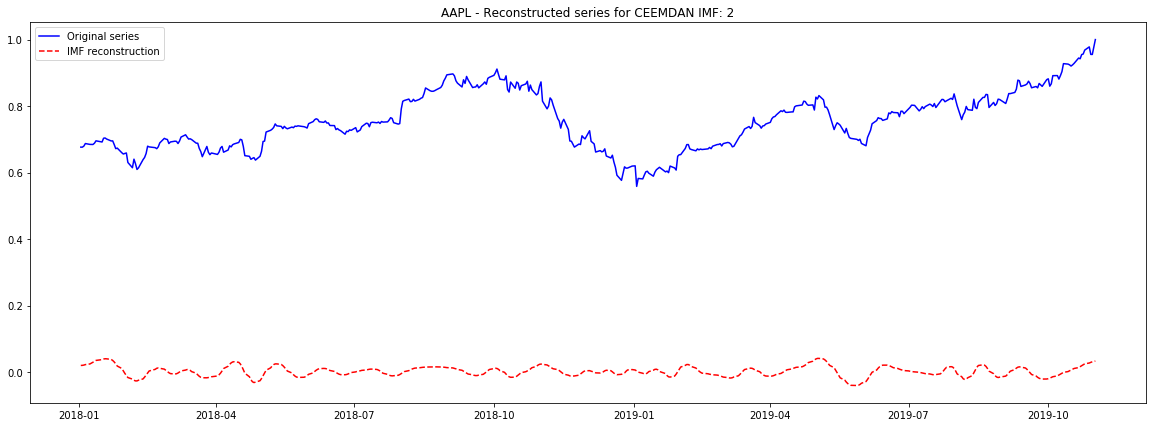

In [7]:
# Reconstring series for filter X
k = 2
reconstructed = []
reconstructed = data_emd[k].copy()
data['EMD'] = reconstructed   
fig = plt.figure(figsize=(20,7))
plt.plot(data[var_selection], color='blue', label = 'Original series')
plt.plot(data['EMD'], color='red', ls='--', label = 'IMF reconstruction')
plt.legend(loc='best')
plt.title('{} - Reconstructed series for {} IMF: {}'.format(ticker, filter_name, k))
plt.savefig('./figures/' + filter_name + '_' + ticker + '_Full_Series_IMF_' + str(k) + '.png')
plt.show()